In [1]:
import pandas as pd
from scipy import sparse # cargar matrices dispersas
from sklearn import model_selection #division de datos
from sklearn.ensemble import RandomForestClassifier #cargamos el modelo RF
# Importar el módulo de métricas de scikit-learn para el cálculo de precisión
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
#metodo para importar datos x, y
def importarDatos (nombre_vector_tfidf, nombreDataset): #carga datos para entrenamiento y prueba
    #cargamos vector de caracteristicas TF-IDF
    tfidf_vector = sparse.load_npz("3.Extraccion_caracteristicas/"+nombre_vector_tfidf)
    x = tfidf_vector.toarray()
    #Cargamos el dataset unido y etiquetado
    tweet_data_df = pd.DataFrame(pd.read_excel(nombreDataset))
    y = tweet_data_df["sentimiento"]
    return x, y

In [8]:
import matplotlib.pyplot as plt
#metodo para graficar datos de entrenamiento y prueba
def graficarDivisionDatos(X_train, X_test):
    col_map = plt.get_cmap('tab10') # color barras
    values = [len(X_train), len(X_test)] 
    labels = ['Entrenamiento', 'Prueba'] 
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
        return my_autopct
    plt.rcParams["figure.facecolor"] = "w"
    plt.pie(values,
           labels=labels,
           colors=col_map.colors,
           textprops={'color':"black",'fontweight':'heavy'},
           shadow=True,
           explode=[0,0.1],
           autopct=make_autopct(values))
    plt.title("Division del dataset en datos\n" + "entrenamiento y prueba", bbox={'facecolor':'0.8', 'pad':5})
    plt.show()

In [4]:
#Metodo para graficar la matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay

def graficar_MatrizConfusion(y_test, predictions):
    cf_matrix=confusion_matrix(y_test,predictions)
    labels=['No depresivo','Depresivo']#modelo_SVM.classes_   1--depresivo
    cm_display = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
    #print(modelo_SVM.classes_)
    dp=cm_display.plot(cmap=plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.rcParams["figure.facecolor"] = "w"
    dp.ax_.set_title('Matriz de Confusion', fontsize=13)
    plt.show()

In [27]:
#VALIDAR PARAMETROS
#Random forest n_estimator and testing accuracy
def validarParametrosRF(X_train, y_train, X_test, y_test):
    scoresrf =[]  # arreglo para guardar los valores
    n_trees=[10,100,200,300,400,500,600,700,800,900,1000]
    for k in n_trees:
        rfc = RandomForestClassifier(n_estimators=k)# la cantidad de arboles en el bosque
        rfc.fit(X_train, y_train)
        y_predrf = rfc.predict(X_test)
        scoresrf.append(accuracy_score(y_test, y_predrf))
    import matplotlib.pyplot as plt
    %matplotlib inline
    #gráfica
    plt.rcParams["figure.facecolor"] = "w"
    plt.plot(ntrees, scoresrf)
    plt.scatter(ntrees,scoresrf) #, color='red'
    plt.xlabel('Valor de n_estimators para Clasificador Random Forest')
    plt.ylabel('Exactitud (accuracy) del Testing')

In [5]:
#Metodo para calcular la validacion cruzada
def validacion_cruzada(modelo_SVM, X_train, y_train):
    scoring = 'accuracy'
    seed=7
    kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle = True) ##shuffle para activar el random state
    cv_results = model_selection.cross_val_score(modelo_SVM, X_train, y_train, cv=kfold, scoring=scoring)
    #results.append(cv_results)
    #names.append(name)
    print("Iteraciones validacion cruzada:\n",cv_results)
    msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
    print("Precision media:\n",msg)

# División de datos en conjuntos de prueba y entrenamiento con Unigramas

### División de datos de entrenamiento y prueba

In [13]:
#Cargamos los datos
x_U, y_U = importarDatos("tfidf_Unigrama.npz","Dataset_unido.xlsx")
#separamos los datos en los conjuntos de entrenamiento prueba
seed = 7
X_train_U, X_test_U, y_train_U, y_test_U = model_selection.train_test_split(x_U, y_U, test_size=0.2, random_state=seed) # 80% training y 20% test

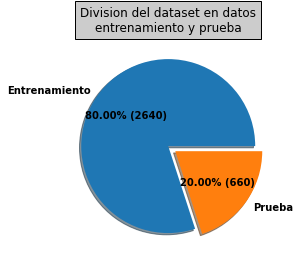

In [9]:
#graficamos la division de datos de entrenamiento y prueba
graficarDivisionDatos(X_train_U, X_test_U)

### Determinar cantidad óptima de árboles (trees) para el modelo

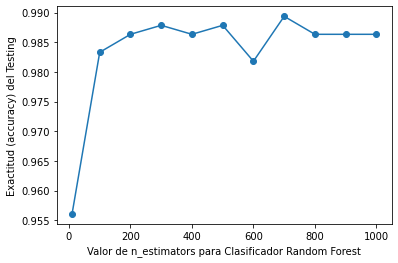

In [28]:
#validar la cantidad optima de arboles (trees) para el modelo RF
validarParametrosRF(X_train_U, y_train_U, X_test_U, y_test_U)

En la fig. anterior podemos observar que el modelo RF con unigramas logra el mejor rendimiento en 
el conjunto de validación cuando n_estimators se establece en 700

### Entrenamiento del modelo

In [36]:
# Crear el modelo de Random Forest
modelo_RF_unigrama = RandomForestClassifier(n_estimators=700)
#Entrena el modelo usando los conjuntos de entrenamiento.
modelo_RF_unigrama.fit(X_train_U, y_train_U)

RandomForestClassifier(n_estimators=700)

### Evaluación del rendimiento del modelo con Validación Cruzada

Validación cruzada

In [30]:
#calculamos la validacion cruzada con los datos de entrenamiento 
validacion_cruzada(modelo_RF_unigrama, X_train_U, y_train_U)

Iteraciones validacion cruzada:
 [0.97916667 0.96780303 0.98295455 0.97348485 0.96780303]
Precision media:
 0.974242 (0.006061)


### Evaluación del modelo con métricas de evaluacion.

In [15]:
# Predecir la respuesta para el conjunto de datos de prueba
predictions_U = modelo_RF_unigrama.predict(X_test_U)
# Precisión del modelo.
print("Exactitud (Accuracy):", accuracy_score(y_test_U, predictions_U))
print(classification_report(y_test_U,predictions_U))


Exactitud (Accuracy): 0.9863636363636363
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       327
           1       0.99      0.98      0.99       333

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660



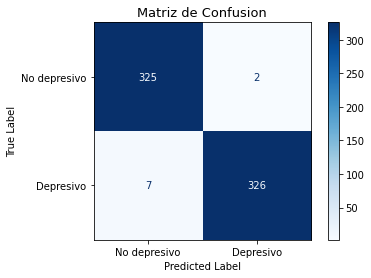

In [38]:
#Graficamos la matriz de confusion para visualizar el desempeño del algoritmo
graficar_MatrizConfusion(y_test_U, predictions_U)

# División de datos en conjuntos de prueba y entrenamiento con Bigramas

### División de datos de entrenamiento y prueba

In [39]:
#Cargamos los datos
x_B, y_B = importarDatos("tfidf_Bigrama.npz","Dataset_unido.xlsx")
#separamos los datos en los conjuntos de entrenamiento prueba
seed = 7
X_train_B, X_test_B, y_train_B, y_test_B = model_selection.train_test_split(x_B, y_B, test_size=0.2, random_state=seed) # 80% training y 20% test

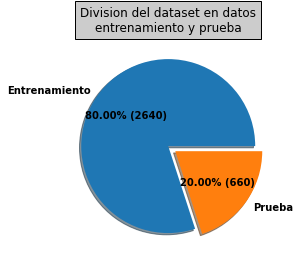

In [40]:
#graficamos la division de datos de entrenamiento y prueba
graficarDivisionDatos(X_train_B, X_test_B)

### Determinar cantidad óptima de árboles (trees) para el modelo

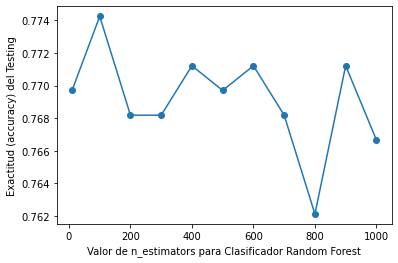

In [45]:
#validar la cantidad óptima de arboles (trees) para el modelo RF
validarParametrosRF(X_train_B, y_train_B, X_test_B, y_test_B)

En la fig. anterior podemos observar que el modelo RF con bigramas logra el mejor rendimiento en el conjunto de validación cuando n_estimators se establece en 100

### Entrenamiento del modelo

In [46]:
# Crear el modelo de Random Forest
modelo_RF_bigrama =  RandomForestClassifier(n_estimators=100)
#Entrena el modelo usando los conjuntos de entrenamiento.
modelo_RF_bigrama.fit(X_train_B, y_train_B)

RandomForestClassifier()

### Evaluación del rendimiento del modelo con Validación Cruzada

In [47]:
#calculamos la validacion cruzada con los datos de entrenamiento 
validacion_cruzada(modelo_RF_bigrama, X_train_B, y_train_B)

Iteraciones validacion cruzada:
 [0.78787879 0.74242424 0.73674242 0.71969697 0.75378788]
Precision media:
 0.748106 (0.022727)


### Evaluación del modelo con métricas de evaluacion.

In [48]:
# Predecir la respuesta para el conjunto de datos de prueba
predictions_B = modelo_RF_bigrama.predict(X_test_B)
# Precisión del modelo.
print("Exactitud (Accuracy):", accuracy_score(y_test_B, predictions_B))
print(classification_report(y_test_B,predictions_B))

Exactitud (Accuracy): 0.7636363636363637
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       327
           1       0.93      0.58      0.71       333

    accuracy                           0.76       660
   macro avg       0.81      0.77      0.76       660
weighted avg       0.81      0.76      0.76       660



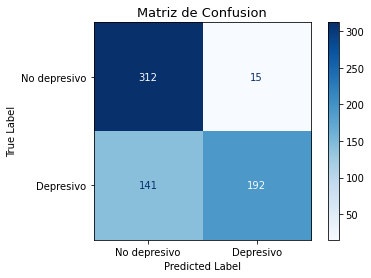

In [49]:
#Graficamos la matriz de confusion para visualizar el desempeño del algoritmo
graficar_MatrizConfusion(y_test_B, predictions_B)

# División de datos en conjuntos de prueba y entrenamiento con Trigramas

In [50]:
#Cargamos los datos
x_T, y_T = importarDatos("tfidf_Trigrama.npz","Dataset_unido.xlsx")
#separamos los datos en los conjuntos de entrenamiento y prueba
seed = 7
X_train_T, X_test_T, y_train_T, y_test_T = model_selection.train_test_split(x_T, y_T, test_size=0.2, random_state=seed) # 80% training y 20% test

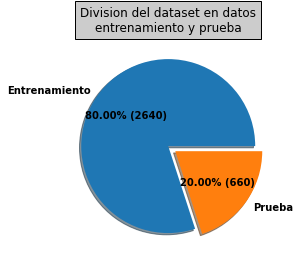

In [51]:
#graficamos la division de datos de entrenamiento y prueba
graficarDivisionDatos(X_train_T, X_test_T)

### Determinar cantidad óptima de árboles (trees) para el modelo

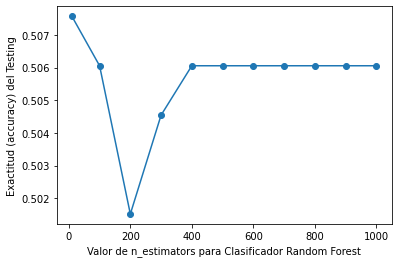

In [63]:
#validar la cantidad óptima de arboles (trees) para el modelo RF
validarParametrosRF(X_train_T, y_train_T, X_test_T, y_test_T)

En la fig. anterior podemos observar que el modelo RF con trigramas variamuy poco respecto a distintas cantidad de arboles, sin embargo logra un rendimiento relativamente mejor en el conjunto de validación cuando n_estimators se establece en 10

### Entrenamiento del modelo

In [65]:
# Crear el modelo de Random Forest
modelo_RF_trigrama =  RandomForestClassifier(n_estimators=10)
#Entrena el modelo usando los conjuntos de entrenamiento.
modelo_RF_trigrama.fit(X_train_T, y_train_T)

RandomForestClassifier(n_estimators=10)

### Evaluación del rendimiento del modelo con Validación Cruzada

In [68]:
#calculamos la validacion cruzada con los datos de entrenamiento 
validacion_cruzada(modelo_RF_trigrama, X_train_T, y_train_T)

Iteraciones validacion cruzada:
 [0.47348485 0.57575758 0.58143939 0.60795455 0.48863636]
Precision media:
 0.545455 (0.053902)


### Evaluación del modelo con métricas de evaluacion.

In [66]:
# Predecir la respuesta para el conjunto de datos de prueba
predictions_T = modelo_RF_trigrama.predict(X_test_T)
# Precisión del modelo.
print("Exactitud (Accuracy):", accuracy_score(y_test_T, predictions_T))
print(classification_report(y_test_T,predictions_T))

Exactitud (Accuracy): 0.5075757575757576
              precision    recall  f1-score   support

           0       0.54      0.04      0.07       327
           1       0.51      0.97      0.66       333

    accuracy                           0.51       660
   macro avg       0.52      0.50      0.37       660
weighted avg       0.52      0.51      0.37       660



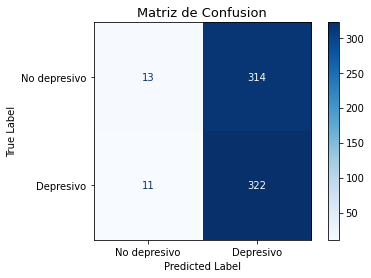

In [69]:
#Graficamos la matriz de confusion para visualizar el desempeño del algoritmo
graficar_MatrizConfusion(y_test_T, predictions_T)

### Comparación del rendimiento de los modelos

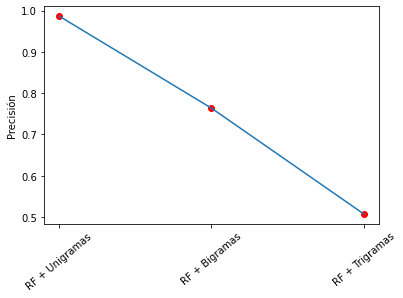

In [71]:
#Comparamos los 3 modelos RF con N-gramas
precisionModelos =[]
precisionModelos.append(accuracy_score(y_test_U, predictions_U))
precisionModelos.append(accuracy_score(y_test_B, predictions_B))
precisionModelos.append(accuracy_score(y_test_T, predictions_T))

#Graficamos
plt.scatter(range(1, 4), precisionModelos, color='red')
plt.plot(range(1, 4), precisionModelos)
plt.xticks([1, 2, 3], ['RF + Unigramas', 'RF + Bigramas', 'RF + Trigramas'], rotation=40)
plt.ylabel('Precisión')
plt.show()

Guardamos el mejor modelo

In [72]:
#Exportamos el modelo de RF con unigramas dado que es el que brinda una mejor precisión
import joblib 
joblib.dump(modelo_RF_unigrama, 'modelo_RF_Unigram.pkl') # Guarda el modelo.

['modelo_RF_Unigram.pkl']